<a href="https://colab.research.google.com/github/csabiu/astronomy/blob/main/Astro_coordinates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install some packages and import them

In [2]:
pip install astroquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 3.9 MB/s 
     |████████████████████████████████| 832 kB 41.9 MB/s 
     |████████████████████████████████| 48 kB 4.6 MB/s 
     |████████████████████████████████| 4.1 MB 36.1 MB/s 


In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
from astropy.io import fits
from astropy.table import QTable
from astropy.utils.data import download_file
from astroquery.gaia import Gaia

Define a target object NGC188 - an open star cluster 

different ways of defining in astropy

In [12]:
ngc188_center = SkyCoord(11.798*u.deg, 85.244*u.deg, frame='icrs')
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (11.798, 85.244)>

In [16]:
ngc188_center = SkyCoord('00h47m11.5s', '85d14m38s', frame='icrs')
ngc188_center 

<SkyCoord (ICRS): (ra, dec) in deg
    (11.79791667, 85.24388889)>

In [17]:
ngc188_center = SkyCoord('00:47:11.5 85:14:38', unit=(u.hour, u.deg), frame='icrs')
ngc188_center 

<SkyCoord (ICRS): (ra, dec) in deg
    (11.79791667, 85.24388889)>

In [18]:
ngc188_center = SkyCoord.from_name('NGC 188')
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (11.798, 85.244)>

Lets search the GAIA database for stars with 0.5 degrees of NGC188 center

In [19]:
Gaia.ROW_LIMIT = 10000  # Set the row limit for returned data

job = Gaia.cone_search_async(ngc188_center, radius=0.5*u.deg)
ngc188_table = job.get_results()

# only keep stars brighter than G=19 magnitude
ngc188_table = ngc188_table[ngc188_table['phot_g_mean_mag'] < 19*u.mag]

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [ ]:
ngc188_table.colnames

['solution_id',
 'DESIGNATION',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g_n_ob

In [20]:
cols = [
    'source_id',
    'ra',
    'dec',
    'parallax',
    'parallax_error',
    'pmra',
    'pmdec',
    'radial_velocity',
    'phot_g_mean_mag',
    'phot_bp_mean_mag',
    'phot_rp_mean_mag'
]
ngc188_table[cols].write('gaia_results.fits', overwrite=True)



In [21]:
ngc188_table = QTable.read('gaia_results.fits')
len(ngc188_table)

4954

Text(0, 0.5, 'Dec [deg]')

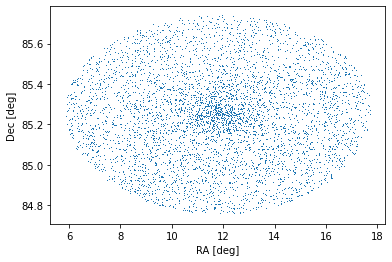

In [25]:
ra=ngc188_table['ra']
dec=ngc188_table['dec']
plt.plot(ra,dec,',')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

In [45]:
ngc188_center.ra

<Longitude 11.798 deg>

In [49]:
def coordinates_aitoff_plot(coords):
    fig, ax = plt.subplots(figsize=(10, 4), 
                           subplot_kw=dict(projection="aitoff"))
    
    sph = coords.spherical
    cs = ax.scatter(-sph.lon.wrap_at(180*u.deg).radian,
                    sph.lat.radian,
                    c=sph.distance.value)

    def fmt_func(x, pos):
        val = coord.Angle(-x*u.radian).wrap_at(360*u.deg).degree
        return f'${val:.0f}' + r'^{\circ}$'

    ticker = mpl.ticker.FuncFormatter(fmt_func)
    ax.xaxis.set_major_formatter(ticker)

    ax.grid()
    
    cb = fig.colorbar(cs)
    cb.set_label('distance [pc]')
    
    return fig, ax



In [27]:
observing_location = EarthLocation(lat='52.2532', lon='351.63910339111703', height=100*u.m)  
observing_time = Time('2017-02-05 20:12:18')  
aa = AltAz(location=observing_location, obstime=observing_time)

coord = SkyCoord('4h42m', '-38d6m50.8s')
bb=coord.transform_to(aa)


In [29]:
tbl = QTable.read('Cantat-Gaudin-open-clusters.ecsv')

In [30]:
open_cluster_c = SkyCoord(
    ra=tbl['ra'],
    dec=tbl['dec'],
    distance=tbl['distance'],
    frame='icrs')
len(open_cluster_c)



474

In [31]:
#lets look at the 1st 4 clusters

In [32]:
open_cluster_c[:4]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [( 51.87 , 34.981,  629.6), (288.399, 36.369,  382.2),
     (295.548, 27.366,  522.9), (298.306, 39.349, 1034.6)]>

Text(0, 0.5, 'Dec [deg]')

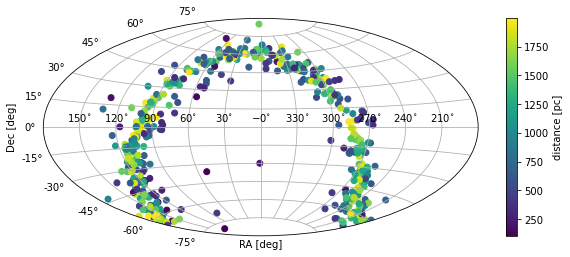

In [50]:
fig, ax = coordinates_aitoff_plot(open_cluster_c)
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

lets translate to Galactic coordinates

In [51]:
open_cluster_gal = open_cluster_c.galactic

Text(0, 0.5, 'Galactic latitude, $b$ [deg]')

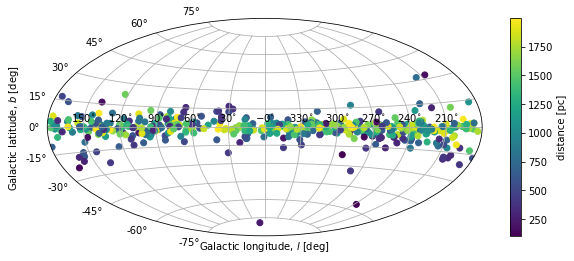

In [52]:
fig, ax = coordinates_aitoff_plot(open_cluster_gal);
ax.set_xlabel('Galactic longitude, $l$ [deg]')
ax.set_ylabel('Galactic latitude, $b$ [deg]')